# CMS Open Payments Data Exploration & Analysis

**Project:** AAI-540 Machine Learning Operations - Final Team Project  
**Dataset:** CMS Open Payments Program Year 2024 General Payments  
**Purpose:** Exploratory Data Analysis for Payment Patterns and Statistical Insights

---

## Table of Contents
1. [Environment Setup & Configuration](#setup)
2. [Data Loading from Datalake](#loading)
3. [Data Quality Assessment](#quality)
4. [Univariate Analysis](#univariate)
5. [Bivariate & Multivariate Analysis](#multivariate)
6. [Temporal Analysis](#temporal)
7. [Geographic Analysis](#geographic)
8. [Feature Engineering](#features)
9. [Outlier Detection](#outliers)
10. [Advanced Visualizations](#advanced)
11. [Key Findings & Insights](#findings)

---

## 1. Environment Setup & Configuration

Setting up the environment with necessary libraries and AWS integration.

In [1]:
# Install required packages
!pip install -r ../requirements.txt --quiet
!pip install boto3 sagemaker awswrangler pyathena --quiet

In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from pathlib import Path
import sys
from scipy import stats

# AWS libraries
import boto3
import sagemaker
import awswrangler as wr
from pyathena import connect

# Add parent directory to path for custom modules
parent_dir = Path.cwd().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

# Visualization settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries imported successfully")

Libraries imported successfully


In [3]:
# Import custom utilities
try:
    from utils.visualizations import PaymentVisualizer
    visualizer = PaymentVisualizer()
    print("Visualization utilities imported successfully")
    use_visualizer = True
except ImportError as e:
    print(f"Could not import visualization utilities: {e}")
    print("Using standard plotting libraries only")
    use_visualizer = False

Visualization utilities imported successfully


In [4]:
# Restore AWS configuration from datalake setup notebook
%store -r bucket
%store -r region
%store -r database_name
%store -r table_name_parquet
%store -r s3_parquet_path
%store -r s3_athena_staging

# If variables not restored, set defaults matching datalake setup
try:
    # Test if variables exist
    test_vars = [bucket, region, database_name, table_name_parquet]
    
    print(f"AWS Configuration:")
    print(f"  Region: {region}")
    print(f"  S3 Bucket: {bucket}")
    print(f"  Database: {database_name}")
    print(f"  Table: {table_name_parquet}")
    print(f"  Parquet Path: {s3_parquet_path}")
    print(f"  Athena Staging: {s3_athena_staging}")
    
except NameError as e:
    print(f"Variables not found in store. Setting up from AWS configuration...")
    
    # Initialize AWS session
    boto_session = boto3.Session()
    region = boto_session.region_name
    
    # Get account information
    sts_client = boto3.client('sts')
    account_id = sts_client.get_caller_identity().get('Account')
    
    # Set configuration matching datalake setup
    #bucket = f"cmsopenpaymentsystems{account_id}"
    bucket = "cmsopenpaymentsystemslight" # changed to this to match Notebook 01 (JN)
    database_name = "cms_open_payments_light"
    table_name_parquet = "general_payments_parquet"
    
    # Define S3 paths
    cms_data_prefix = "cms-open-payments_light"
    parquet_data_prefix = f"{cms_data_prefix}/parquet"
    s3_parquet_path = f"s3://{bucket}/{parquet_data_prefix}"
    s3_athena_staging = f"s3://{bucket}/athena/staging"
    
    print(f"\nAWS Configuration (manual setup):")
    print(f"  Region: {region}")
    print(f"  Account ID: {account_id}")
    print(f"  S3 Bucket: {bucket}")
    print(f"  Database: {database_name}")
    print(f"  Table: {table_name_parquet}")
    print(f"  Parquet Path: {s3_parquet_path}")
    print(f"  Athena Staging: {s3_athena_staging}")
    print(f"\nNote: Please run the datalake setup notebook (01_setup_cms_datalake.ipynb) first for full setup.")

AWS Configuration:
  Region: us-east-1
  S3 Bucket: cmsopenpaymentsystemslight
  Database: cms_open_payments_light
  Table: general_payments_parquet
  Parquet Path: s3://cmsopenpaymentsystemslight/cms-open-payments-light/parquet
  Athena Staging: s3://cmsopenpaymentsystemslight/athena/staging


## 2. Data Loading from Datalake

Load CMS Open Payments data from AWS Athena using optimized Parquet format.

In [5]:
# Initialize Athena connection
athena_conn = connect(
    region_name=region,
    s3_staging_dir=s3_athena_staging
)

print("Athena connection established")

Athena connection established


In [6]:
# Option 1: Load full dataset from Parquet (recommended for complete analysis)
# Note: This may take several minutes and require substantial memory

load_full_dataset = False  # Set to True to load full dataset

if load_full_dataset:
    print("Loading full dataset from Parquet...")
    print("Note: This may take several minutes")
    
    df = wr.athena.read_sql_query(
        sql=f"SELECT * FROM {database_name}.{table_name_parquet}",
        database=database_name,
        ctas_approach=False
    )
    
    print(f"Full dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
else:
    print("Skipping full dataset load - will use sample queries instead")

Skipping full dataset load - will use sample queries instead


In [7]:
# Option 2: Load sample dataset for faster EDA
sample_size = 100000  # Adjust based on your needs

print(f"Loading sample dataset ({sample_size:,} rows)...")

sample_query = f"""
SELECT *
FROM {database_name}.{table_name_parquet}
LIMIT {sample_size}
"""

df = wr.athena.read_sql_query(
    sql=sample_query,
    database=database_name,
    ctas_approach=False
)

print(f"Sample dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"  Memory Usage: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Loading sample dataset (100,000 rows)...
Sample dataset loaded: 100,000 rows, 91 columns
  Memory Usage: 196.95 MB


In [8]:
# Preview the data
print("Dataset Preview:")
display(df.head(3))

print(f"\nDataset Info:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {df.shape[1]}")
print(f"\nColumn Names:")
for i, col in enumerate(df.columns[:20], 1):
    print(f"  {i}. {col}")
if len(df.columns) > 20:
    print(f"  ... ({len(df.columns) - 20} more columns)")

Dataset Preview:


,change_type,covered_recipient_type,teaching_hospital_ccn,teaching_hospital_id,teaching_hospital_name,covered_recipient_profile_id,covered_recipient_npi,covered_recipient_first_name,covered_recipient_middle_name,covered_recipient_last_name,covered_recipient_name_suffix,recipient_primary_business_street_address_line1,recipient_primary_business_street_address_line2,recipient_city,recipient_state,recipient_zip_code,recipient_country,recipient_province,recipient_postal_code,covered_recipient_primary_type_1,covered_recipient_primary_type_2,covered_recipient_primary_type_3,covered_recipient_primary_type_4,covered_recipient_primary_type_5,covered_recipient_primary_type_6,...,indicate_drug_or_biological_or_device_or_medical_supply_2,product_category_or_therapeutic_area_2,name_of_drug_or_biological_or_device_or_medical_supply_2,associated_drug_or_biological_ndc_2,associated_device_or_medical_supply_pdi_2,covered_or_noncovered_indicator_3,indicate_drug_or_biological_or_device_or_medical_supply_3,product_category_or_therapeutic_area_3,name_of_drug_or_biological_or_device_or_medical_supply_3,associated_drug_or_biological_ndc_3,associated_device_or_medical_supply_pdi_3,covered_or_noncovered_indicator_4,indicate_drug_or_biological_or_device_or_medical_supply_4,product_category_or_therapeutic_area_4,name_of_drug_or_biological_or_device_or_medical_supply_4,associated_drug_or_biological_ndc_4,associated_device_or_medical_supply_pdi_4,covered_or_noncovered_indicator_5,indicate_drug_or_biological_or_device_or_medical_supply_5,product_category_or_therapeutic_area_5,name_of_drug_or_biological_or_device_or_medical_supply_5,associated_drug_or_biological_ndc_5,associated_device_or_medical_supply_pdi_5,payment_publication_date,program_year
0,NEW,Covered Recipient Non-Physician Practitioner,<NA>,<NA>,<NA>,10674172.00,1851955819.00,NaN,NaN,NaN,NaN,2712 LAWRENCEVILLE HWY,NaN,DECATUR,GA,30033,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06/30/2025,2024
1,NEW,Covered Recipient Non-Physician Practitioner,<NA>,<NA>,<NA>,10946129.00,1598778680.00,NaN,NaN,NaN,NaN,511 IDLEWILD AVE,NaN,EASTON,MD,21601,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,2024
2,NEW,Covered Recipient Physician,<NA>,<NA>,<NA>,242257.00,1336127380.00,NaN,NaN,NaN,NaN,2073 Klockner Rd,NaN,Trenton,NJ,8690,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06/30/2025,2024



Dataset Info:
  Shape: (100000, 91)
  Columns: 91

Column Names:
  1. change_type
  2. covered_recipient_type
  3. teaching_hospital_ccn
  4. teaching_hospital_id
  5. teaching_hospital_name
  6. covered_recipient_profile_id
  7. covered_recipient_npi
  8. covered_recipient_first_name
  9. covered_recipient_middle_name
  10. covered_recipient_last_name
  11. covered_recipient_name_suffix
  12. recipient_primary_business_street_address_line1
  13. recipient_primary_business_street_address_line2
  14. recipient_city
  15. recipient_state
  16. recipient_zip_code
  17. recipient_country
  18. recipient_province
  19. recipient_postal_code
  20. covered_recipient_primary_type_1
  ... (71 more columns)


In [9]:
# Data preprocessing
print("Preprocessing data...")

# Identify and convert date columns
date_columns = [col for col in df.columns if 'date' in col.lower() or 'Date' in col]
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Identify numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
print(f"  Date columns: {len(date_columns)}")
print(f"  Numeric columns: {len(numeric_cols)}")

# Create temporal features if date column exists
payment_date_col = 'date_of_payment'
if payment_date_col in df.columns:
    df['payment_year'] = df[payment_date_col].dt.year
    df['payment_month'] = df[payment_date_col].dt.month
    df['payment_quarter'] = df[payment_date_col].dt.quarter
    df['payment_dayofweek'] = df[payment_date_col].dt.dayofweek
    df['payment_week'] = df[payment_date_col].dt.isocalendar().week
    print(f"Temporal features created")

print(f"Preprocessing complete")

Preprocessing data...
  Date columns: 2
  Numeric columns: 65
Temporal features created
Preprocessing complete


In [10]:
# Detect and set column name variables dynamically
print("Detecting key column names...")

# Payment amount column - look for variations
payment_col_options = ['total_amount_of_payment_usdollars', 'total_amount_of_payment_usdollars', 
                       'total_amount', 'amount', 'payment_amount']
payment_col = None
for col in payment_col_options:
    if col in df.columns:
        payment_col = col
        break

# If not found, look for columns containing 'amount'
if payment_col is None:
    amount_cols = [col for col in df.columns if 'amount' in col.lower()]
    if len(amount_cols) > 0:
        payment_col = amount_cols[0]

print(f"  Payment amount column: {payment_col}")

# Recipient type column
recipient_type_col_options = ['covered_recipient_type', 'recipient_type', 'recipienttype']
recipient_type_col = None
for col in recipient_type_col_options:
    if col in df.columns:
        recipient_type_col = col
        break

# If not found, look for columns containing 'recipient' and 'type'
if recipient_type_col is None:
    type_cols = [col for col in df.columns if 'recipient' in col.lower() and 'type' in col.lower()]
    if len(type_cols) > 0:
        recipient_type_col = type_cols[0]

print(f"  Recipient type column: {recipient_type_col}")

# Recipient ID columns
recipient_id_cols = [col for col in df.columns if 'recipient' in col.lower() and 'id' in col.lower()]
print(f"  Recipient ID columns: {len(recipient_id_cols)} found")
if len(recipient_id_cols) > 0:
    print(f"    Using: {recipient_id_cols[0]}")

# State column
state_col_options = ['recipient_state', 'recipient_state', 'state']
state_col = None
for col in state_col_options:
    if col in df.columns:
        state_col = col
        break

# If not found, look for columns containing 'state'
if state_col is None:
    state_cols = [col for col in df.columns if 'state' in col.lower() and 'recipient' in col.lower()]
    if len(state_cols) > 0:
        state_col = state_cols[0]

print(f"  State column: {state_col}")

# City column
city_col_options = ['recipient_City', 'city']
city_col = None
for col in city_col_options:
    if col in df.columns:
        city_col = col
        break

if city_col is None:
    city_cols = [col for col in df.columns if 'city' in col.lower() and 'recipient' in col.lower()]
    if len(city_cols) > 0:
        city_col = city_cols[0]

print(f"  City column: {city_col}")

print("\nColumn detection complete!")

Detecting key column names...
  Payment amount column: total_amount_of_payment_usdollars
  Recipient type column: covered_recipient_type
  Recipient ID columns: 2 found
    Using: covered_recipient_profile_id
  State column: recipient_state
  City column: recipient_city

Column detection complete!


## 3. Data Quality Assessment

Comprehensive assessment of data quality including completeness, validity, and consistency.

In [11]:
# Basic statistics
print("=" * 70)
print("DATASET BASIC STATISTICS")
print("=" * 70)

print(f"\nDimensions:")
print(f"  Total Rows: {df.shape[0]:,}")
print(f"  Total Columns: {df.shape[1]}")

print(f"\nMemory Usage:")
memory_mb = df.memory_usage(deep=True).sum() / (1024**2)
print(f"  Total: {memory_mb:.2f} MB")
print(f"  Per Row: {memory_mb / df.shape[0] * 1024:.2f} KB")

print(f"\nColumn Types:")
print(f"  Numeric: {len(df.select_dtypes(include=['number']).columns)}")
print(f"  Object/String: {len(df.select_dtypes(include=['object']).columns)}")
print(f"  DateTime: {len(df.select_dtypes(include=['datetime']).columns)}")

print(f"\nMissing Values:")
total_cells = df.shape[0] * df.shape[1]
missing_cells = df.isnull().sum().sum()
print(f"  Total Cells: {total_cells:,}")
print(f"  Missing Cells: {missing_cells:,}")
print(f"  Missing Percentage: {(missing_cells/total_cells)*100:.2f}%")

print(f"\nDuplicate Rows:")
duplicates = df.duplicated().sum()
print(f"  Count: {duplicates:,}")
print(f"  Percentage: {(duplicates/df.shape[0])*100:.2f}%")

DATASET BASIC STATISTICS

Dimensions:
  Total Rows: 100,000
  Total Columns: 96

Memory Usage:
  Total: 190.85 MB
  Per Row: 1.95 KB

Column Types:
  Numeric: 70
  Object/String: 0
  DateTime: 2

Missing Values:
  Total Cells: 9,600,000
  Missing Cells: 6,553,852
  Missing Percentage: 68.27%

Duplicate Rows:
  Count: 0
  Percentage: 0.00%


In [12]:
# Missing values analysis
print("Missing Values by Column (Top 20):")

missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percent': (df.isnull().sum().values / len(df) * 100)
})

missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values(
    'Missing_Percent', ascending=False
)

display(missing_stats.head(20))

Missing Values by Column (Top 20):


,Column,Missing_Count,Missing_Percent
9,covered_recipient_last_name,100000,100.00
7,covered_recipient_first_name,100000,100.00
21,covered_recipient_primary_type_3,100000,100.00
22,covered_recipient_primary_type_4,100000,100.00
23,covered_recipient_primary_type_5,100000,100.00
24,covered_recipient_primary_type_6,100000,100.00
25,covered_recipient_specialty_1,100000,100.00
26,covered_recipient_specialty_2,100000,100.00
27,covered_recipient_specialty_3,100000,100.00
20,covered_recipient_primary_type_2,100000,100.00


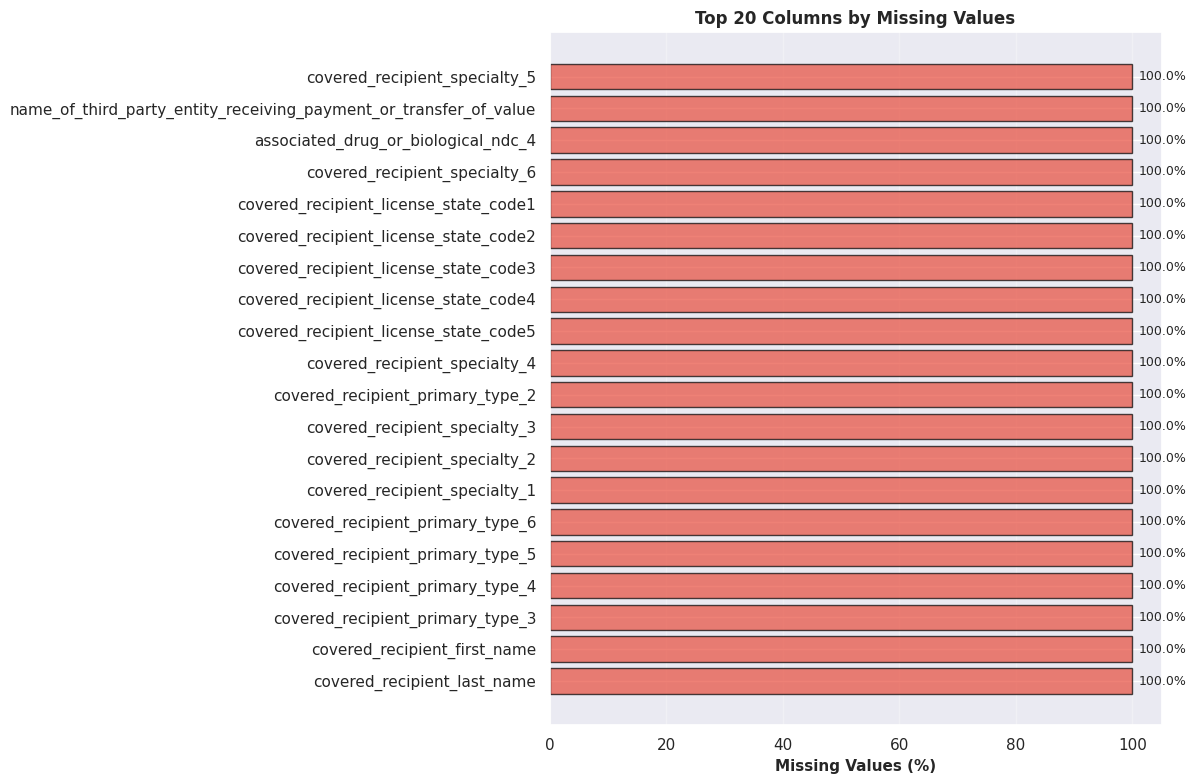

In [13]:
# Visualize missing values
if len(missing_stats) > 0:
    if use_visualizer:
        fig = visualizer.plot_missing_values(df, top_n=20)
        if fig:
            plt.show()
    else:
        print("Visualizer not available - skipping plot")
else:
    print("No missing values detected")

In [14]:
# Data types summary
print("\nData Types Summary:")
print(df.dtypes.value_counts())

print("\n Sample of each data type:")
for dtype in df.dtypes.unique():
    cols = df.select_dtypes(include=[dtype]).columns[:3]
    print(f"  {dtype}: {', '.join(cols)}")


Data Types Summary:
float64           63
string[python]    24
Int64              6
datetime64[ns]     2
UInt32             1
Name: count, dtype: int64

 Sample of each data type:
  string: change_type, covered_recipient_type, teaching_hospital_name
  Int64: teaching_hospital_ccn, teaching_hospital_id, recipient_zip_code
  float64: covered_recipient_profile_id, covered_recipient_npi, covered_recipient_first_name
  datetime64[ns]: date_of_payment, payment_publication_date
  UInt32: payment_week


## 4. Univariate Analysis

Analyzing individual variables to understand distributions, central tendencies, and variability.

In [15]:
# Payment amount analysis
if payment_col and payment_col in df.columns:
    print("=" * 70)
    print("PAYMENT AMOUNT STATISTICS")
    print("=" * 70)
    
    payment_stats = df[payment_col].describe()
    
    print(f"\nBasic Statistics:")
    print(f"  Count: {payment_stats['count']:,.0f}")
    print(f"  Mean: ${payment_stats['mean']:,.2f}")
    print(f"  Median: ${payment_stats['50%']:,.2f}")
    print(f"  Std Dev: ${payment_stats['std']:,.2f}")
    print(f"  Min: ${payment_stats['min']:,.2f}")
    print(f"  Max: ${payment_stats['max']:,.2f}")
    
    print(f"\nQuartiles:")
    print(f"  25th percentile: ${payment_stats['25%']:,.2f}")
    print(f"  50th percentile: ${payment_stats['50%']:,.2f}")
    print(f"  75th percentile: ${payment_stats['75%']:,.2f}")
    
    print(f"\nAdditional Percentiles:")
    for p in [90, 95, 99, 99.9]:
        val = df[payment_col].quantile(p/100)
        print(f"  {p}th percentile: ${val:,.2f}")
    
    # Skewness and Kurtosis
    skewness = df[payment_col].skew()
    kurtosis = df[payment_col].kurtosis()
    print(f"\nDistribution Shape:")
    print(f"  Skewness: {skewness:.2f}")
    print(f"  Kurtosis: {kurtosis:.2f}")
else:
    print(f"Warning: Payment column '{payment_col}' not found in dataframe")

PAYMENT AMOUNT STATISTICS

Basic Statistics:
  Count: 55,340
  Mean: $9,035,211.97
  Median: $20.08
  Std Dev: $950,495,091.96
  Min: $0.01
  Max: $100,000,151,638.00

Quartiles:
  25th percentile: $15.16
  50th percentile: $20.08
  75th percentile: $28.11

Additional Percentiles:
  90th percentile: $110.48
  95th percentile: $173.99
  99th percentile: $2,700.00
  99.9th percentile: $13,276.95

Distribution Shape:
  Skewness: 105.19
  Kurtosis: 11064.00


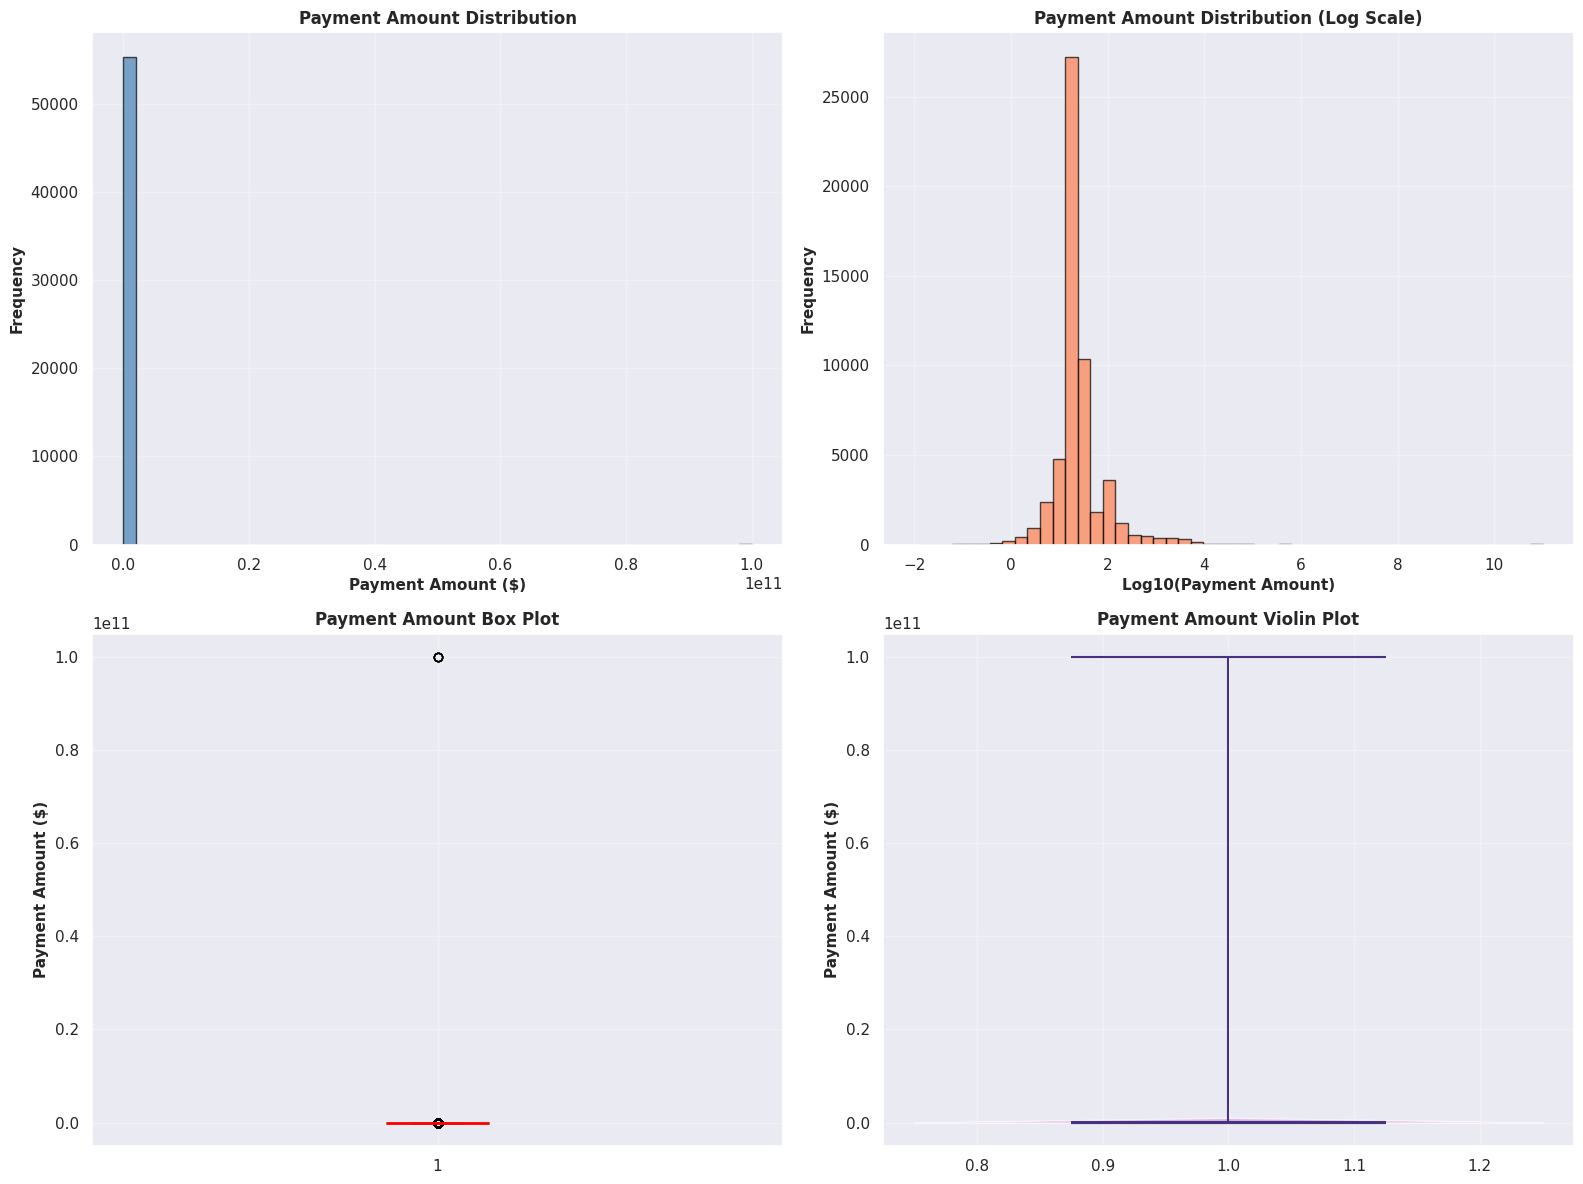

In [16]:
# Visualize payment distribution
if payment_col and payment_col in df.columns:
    if use_visualizer:
        fig = visualizer.plot_payment_distribution_detailed(df, payment_col=payment_col)
        plt.show()
    else:
        print("Visualizer not available - skipping plot")

In [17]:
# Categorical variables analysis
print("=" * 70)
print("CATEGORICAL VARIABLES ANALYSIS")
print("=" * 70)

categorical_cols = [
    'change_type',
    'covered_recipient_type',
    'form_of_payment_or_transfer_of_value',
    'nature_of_payment_or_transfer_of_value'
]

for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        value_counts = df[col].value_counts().head(10)
        print(value_counts)
        print(f"  Unique values: {df[col].nunique()}")
        print(f"  Missing values: {df[col].isnull().sum()} ({df[col].isnull().sum()/len(df)*100:.1f}%)")

CATEGORICAL VARIABLES ANALYSIS

change_type:
change_type
NEW    99996
ADD        4
Name: count, dtype: Int64
  Unique values: 2
  Missing values: 0 (0.0%)

covered_recipient_type:
covered_recipient_type
Covered Recipient Physician                     64293
Covered Recipient Non-Physician Practitioner    35496
Covered Recipient Teaching Hospital               211
Name: count, dtype: Int64
  Unique values: 3
  Missing values: 0 (0.0%)

form_of_payment_or_transfer_of_value:
form_of_payment_or_transfer_of_value
In-kind items and services    48361
Cash or cash equivalent        6972
1                              6682
United States                  2162
10/29/2024                      198
10/24/2024                      197
02/21/2024                      193
09/17/2024                      192
09/10/2024                      189
11/13/2024                      189
Name: count, dtype: Int64
  Unique values: 1010
  Missing values: 0 (0.0%)

nature_of_payment_or_transfer_of_value:
nature_of_p


covered_recipient_type Distribution:


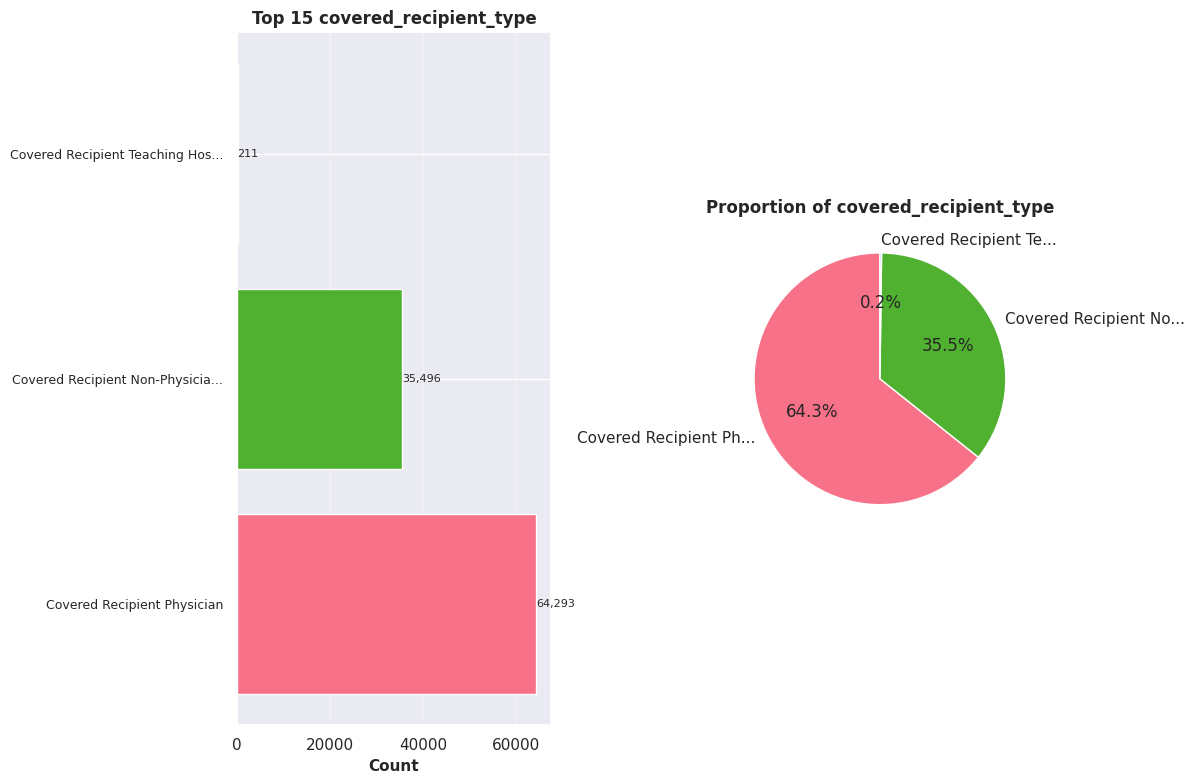


form_of_payment_or_transfer_of_value Distribution:


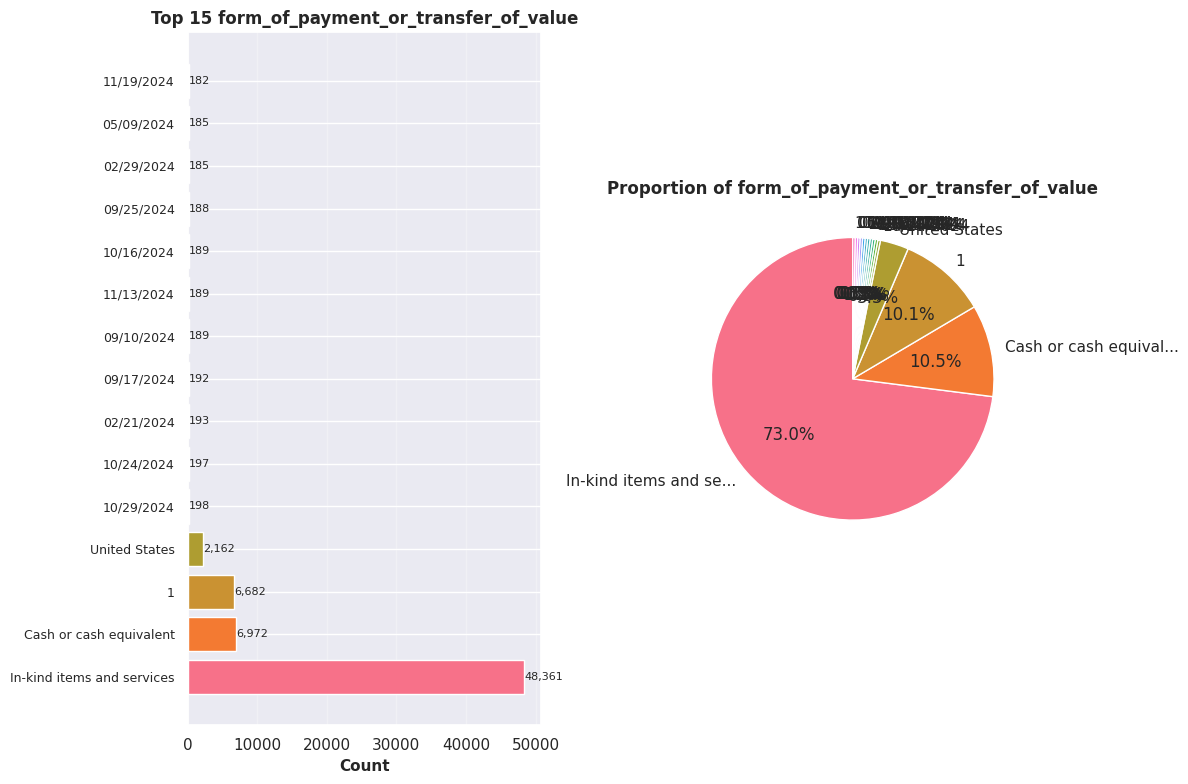


nature_of_payment_or_transfer_of_value Distribution:


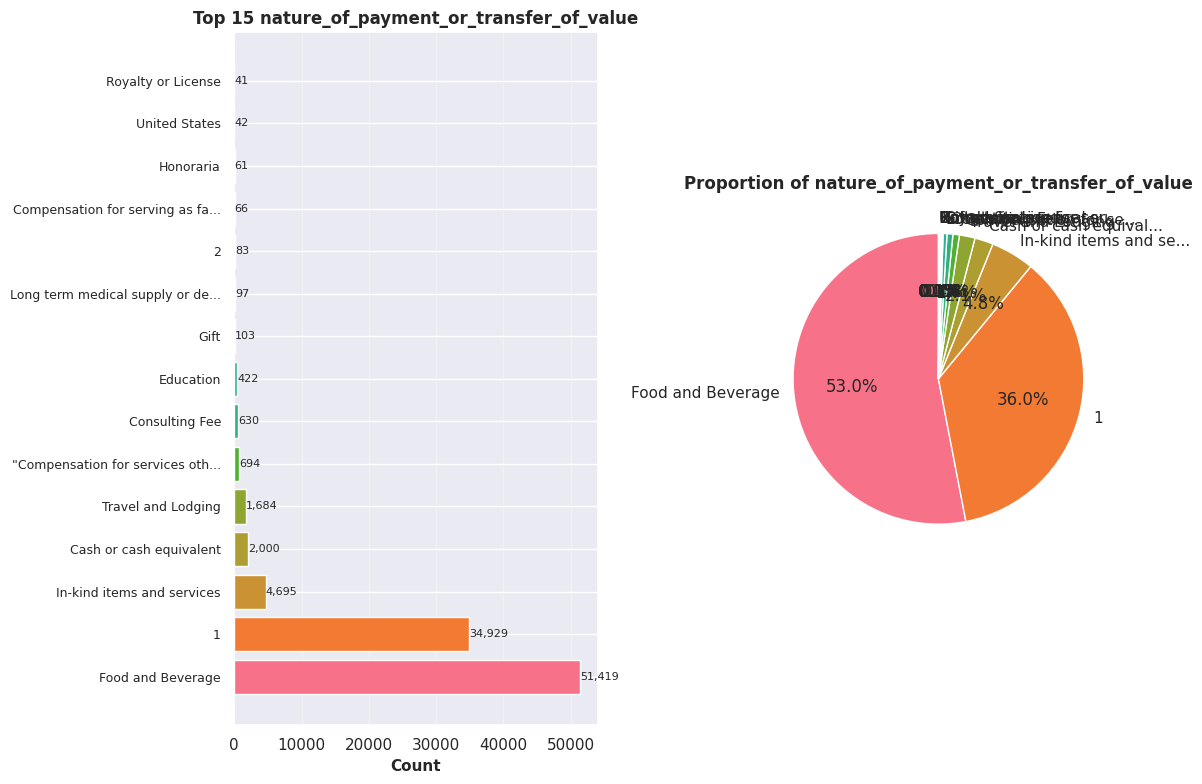

In [18]:
# Visualize categorical distributions separately
categorical_cols_viz = [
    'covered_recipient_type',
    'form_of_payment_or_transfer_of_value',
    'nature_of_payment_or_transfer_of_value'
]

for col in categorical_cols_viz:
    if col in df.columns and use_visualizer:
        print(f"\n{col} Distribution:")
        fig = visualizer.plot_category_distribution(df, col, top_n=15)
        if fig:
            plt.show()
    elif col not in df.columns:
        print(f"Column {col} not found in dataframe")

## 5. Bivariate & Multivariate Analysis

Explore relationships between multiple variables.

In [19]:
# Payment amount by recipient type
recipient_type_col = 'covered_recipient_type'

if recipient_type_col in df.columns and payment_col in df.columns:
    print("=" * 70)
    print("PAYMENT STATISTICS BY RECIPIENT TYPE")
    print("=" * 70)
    
    type_stats = df.groupby(recipient_type_col)[payment_col].agg([
        'count', 'sum', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)
    
    type_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)', 'Std Dev ($)', 'Min ($)', 'Max ($)']
    type_stats = type_stats.sort_values('Total ($)', ascending=False)
    
    display(type_stats)

PAYMENT STATISTICS BY RECIPIENT TYPE


,Count,Total ($),Mean ($),Median ($),Std Dev ($),Min ($),Max ($)
covered_recipient_type,,,,,,,
Covered Recipient Physician,35831,300006573431.15,8372821.67,20.93,914996169.51,0.01,100000151638.00
Covered Recipient Non-Physician Practitioner,19384,200000797111.30,10317828.99,18.78,1015738977.80,0.08,100000011150.00
Covered Recipient Teaching Hospital,125,1259794.64,10078.36,1368.26,57548.64,6.07,627450.00


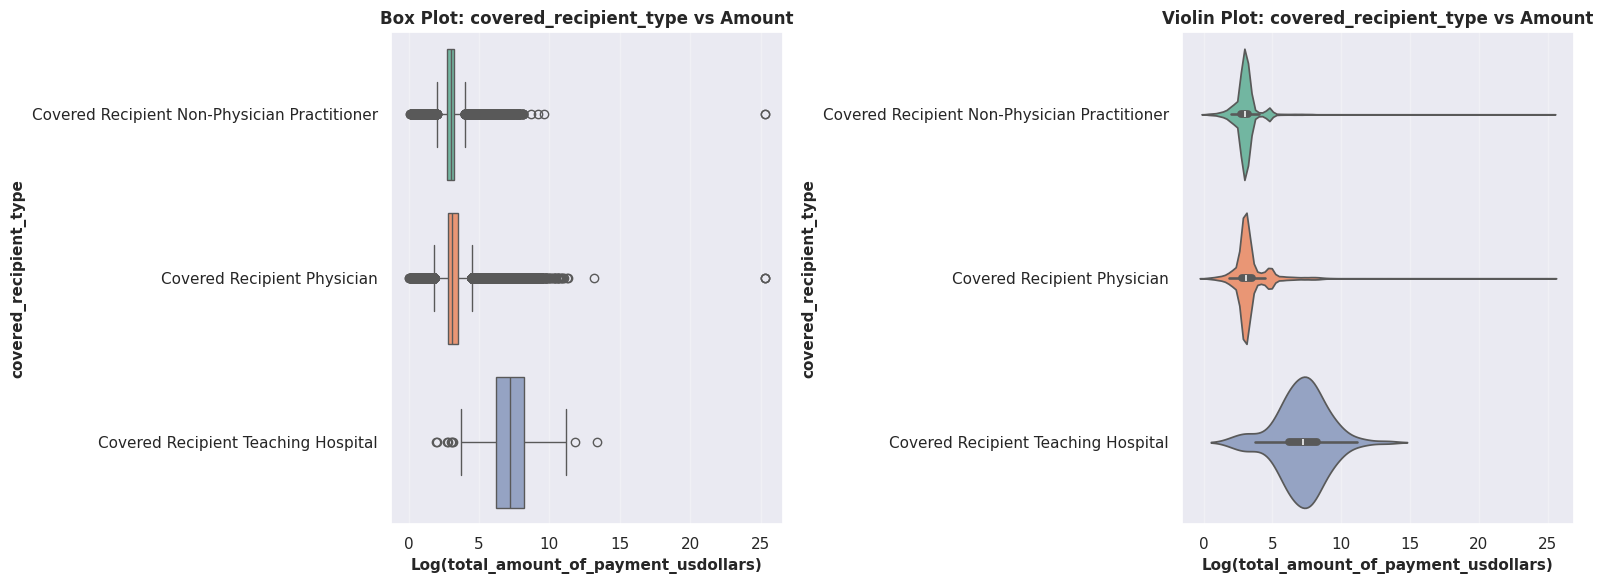

In [20]:
# Visualize payment by recipient type
if recipient_type_col and recipient_type_col in df.columns and payment_col and payment_col in df.columns:
    if use_visualizer:
        # Bivariate comparison plot
        fig = visualizer.plot_bivariate_comparison(df, group_col=recipient_type_col, 
                                                   amount_col=payment_col)
        plt.show()
    else:
        print("Visualizer not available - skipping plot")

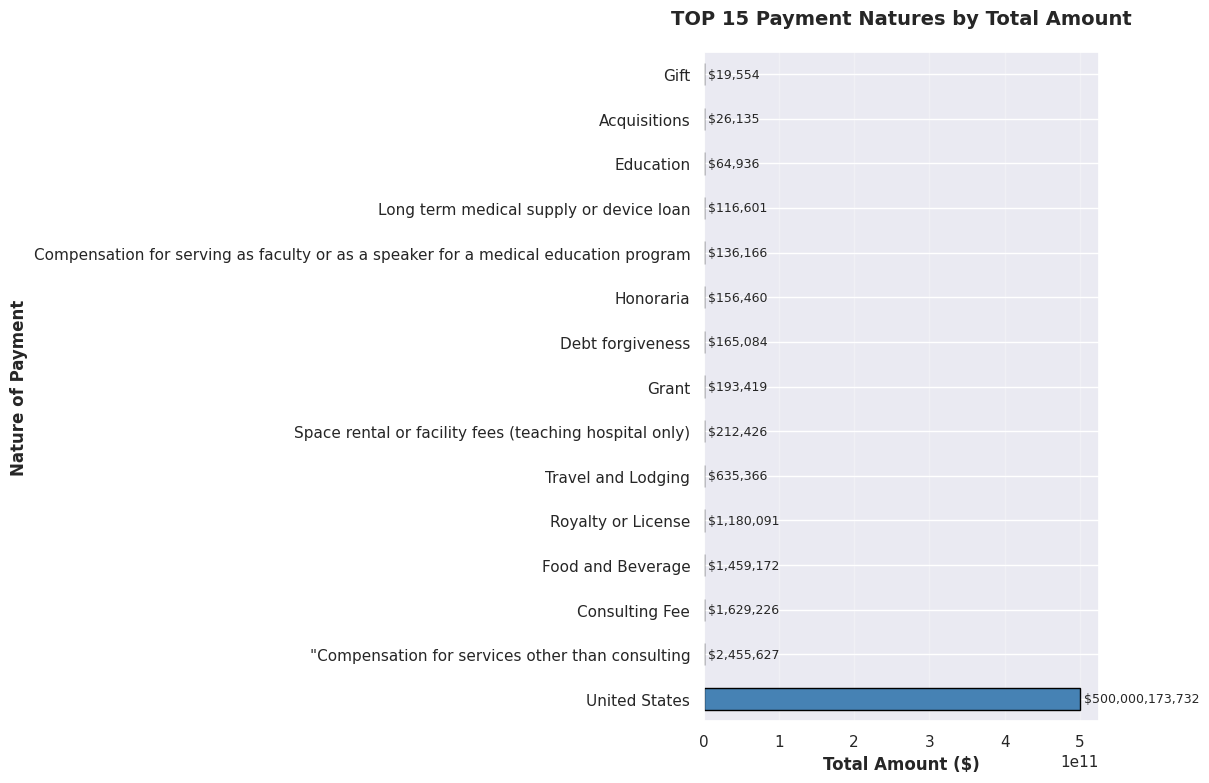

In [21]:
# Payment nature analysis and visualization
if use_visualizer:
    try:
        # Call visualizer with correct column names
        visualizer.plot_payment_nature_by_total(
            df,
            nature_col='nature_of_payment_or_transfer_of_value',  # Correct column name
            amount_col='total_amount_of_payment_usdollars',       # Ensure this matches your DataFrame
            top_n=15
        )
    except KeyError as e:
        print(f"Column name error: {e}")

## 6. Temporal Analysis

Analyze payment patterns over time.

Analyzing correlations for 5 numeric features


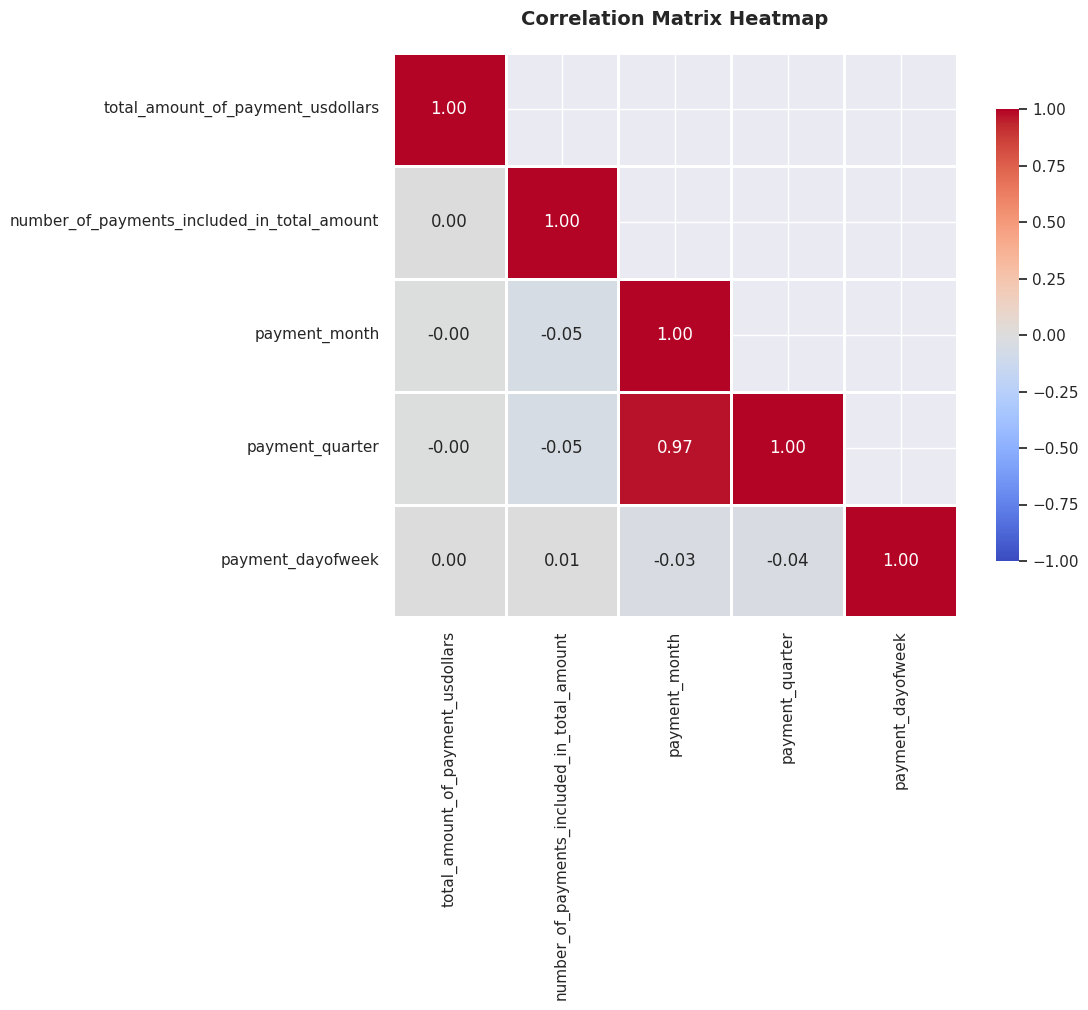

In [22]:
# Correlation analysis for numeric features
if payment_col and payment_col in df.columns:
    numeric_features = [payment_col]
    
    # Add other numeric columns if available
    potential_numeric = ['number_of_payments_included_in_total_amount', 
                        'payment_month', 'payment_quarter', 'payment_dayofweek']
    
    for col in potential_numeric:
        if col in df.columns:
            numeric_features.append(col)
    
    if len(numeric_features) > 2 and use_visualizer:
        print(f"Analyzing correlations for {len(numeric_features)} numeric features")
        fig = visualizer.plot_correlation_heatmap(df, numeric_features)
        if fig:
            plt.show()
    else:
        print(f"Not enough numeric features for correlation analysis ({len(numeric_features)} found)")

### Correlation Analysis

Explore correlations between numeric features.

In [23]:
# Monthly payment trends
if 'payment_month' in df.columns and payment_col in df.columns:
    print("=" * 70)
    print("MONTHLY PAYMENT STATISTICS")
    print("=" * 70)
    
    monthly_stats = df.groupby('payment_month')[payment_col].agg([
        'count', 'sum', 'mean', 'median'
    ]).round(2)
    
    monthly_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)']
    monthly_stats.index.name = 'Month'
    
    print(monthly_stats)

MONTHLY PAYMENT STATISTICS
       Count  Total ($)  Mean ($)  Median ($)
Month                                        
1.00    4425  735566.44    166.23       19.40
2.00    4901 1316916.39    268.70       19.95
3.00    4832  545321.93    112.86       20.02
4.00    5106  544392.18    106.62       20.13
5.00    5059  822428.00    162.57       20.00
6.00    4355  571446.11    131.22       20.37
7.00    4405  530271.68    120.38       19.73
8.00    4715  583037.36    123.66       19.54
9.00    4560  484657.05    106.28       20.38
10.00   5332  590082.73    110.67       20.52
11.00   4254 1234127.91    290.11       20.88
12.00   3391  498357.31    146.96       20.72


### Monthly Payment Statistics

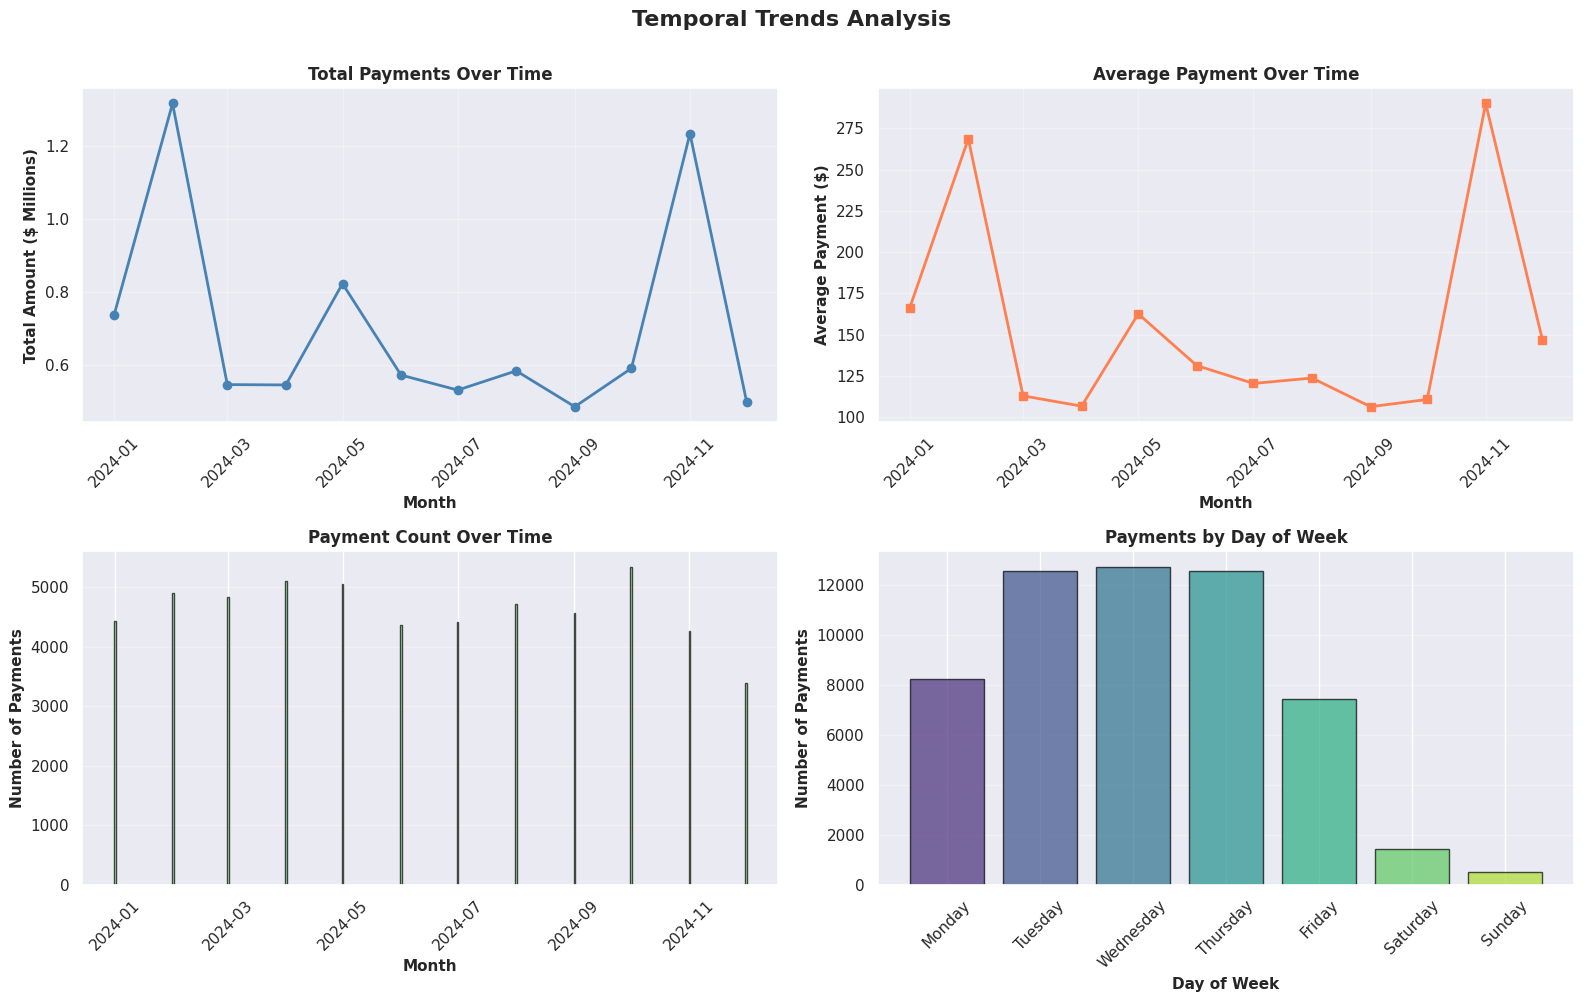

In [24]:
# Comprehensive temporal trends visualization
if 'date_of_payment' in df.columns and payment_col and payment_col in df.columns:
    if use_visualizer:
        fig = visualizer.plot_temporal_trends(df, date_col='date_of_payment', 
                                             amount_col=payment_col)
        if fig:
            plt.show()
    else:
        print("Visualizer not available - skipping plot")

### Temporal Trends Overview

Visualize overall temporal patterns in payments.

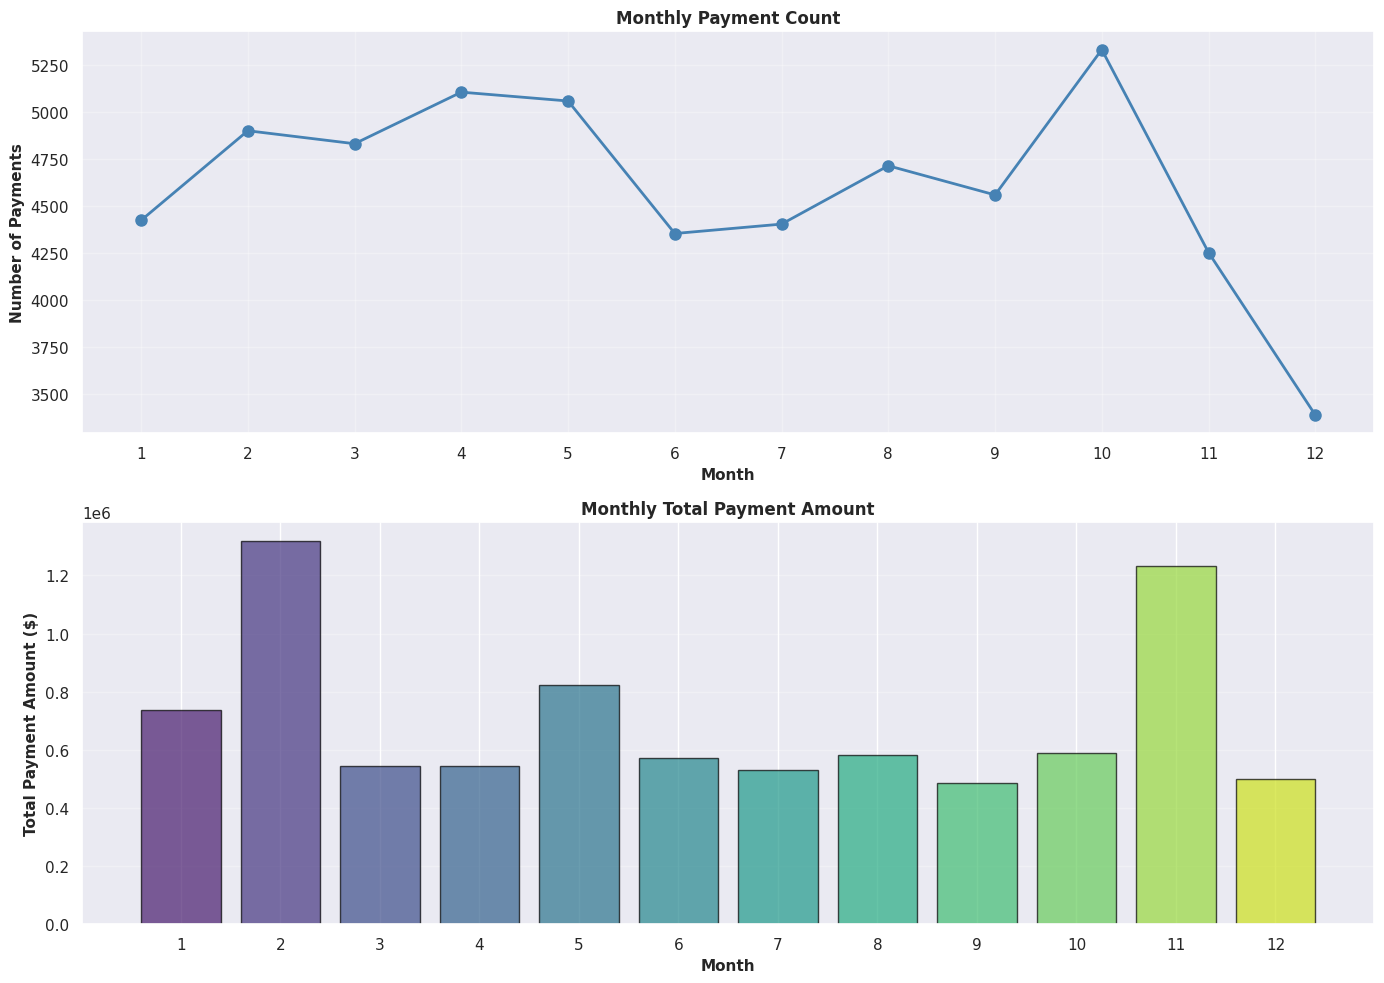

In [25]:
# Visualize monthly trends
if 'payment_month' in df.columns and payment_col and payment_col in df.columns:
    if use_visualizer:
        fig = visualizer.plot_monthly_trends(df, payment_col=payment_col, month_col='payment_month')
        plt.show()
    else:
        print("Visualizer not available - skipping plot")

### Quarterly Payment Statistics

QUARTERLY PAYMENT STATISTICS


,Count,Total ($),Mean ($),Median ($)
Quarter,,,,
1.00,14158,2597804.76,183.49,19.79
2.00,14520,1938266.29,133.49,20.15
3.00,13680,1597966.09,116.81,19.88
4.00,12977,2322567.95,178.98,20.68


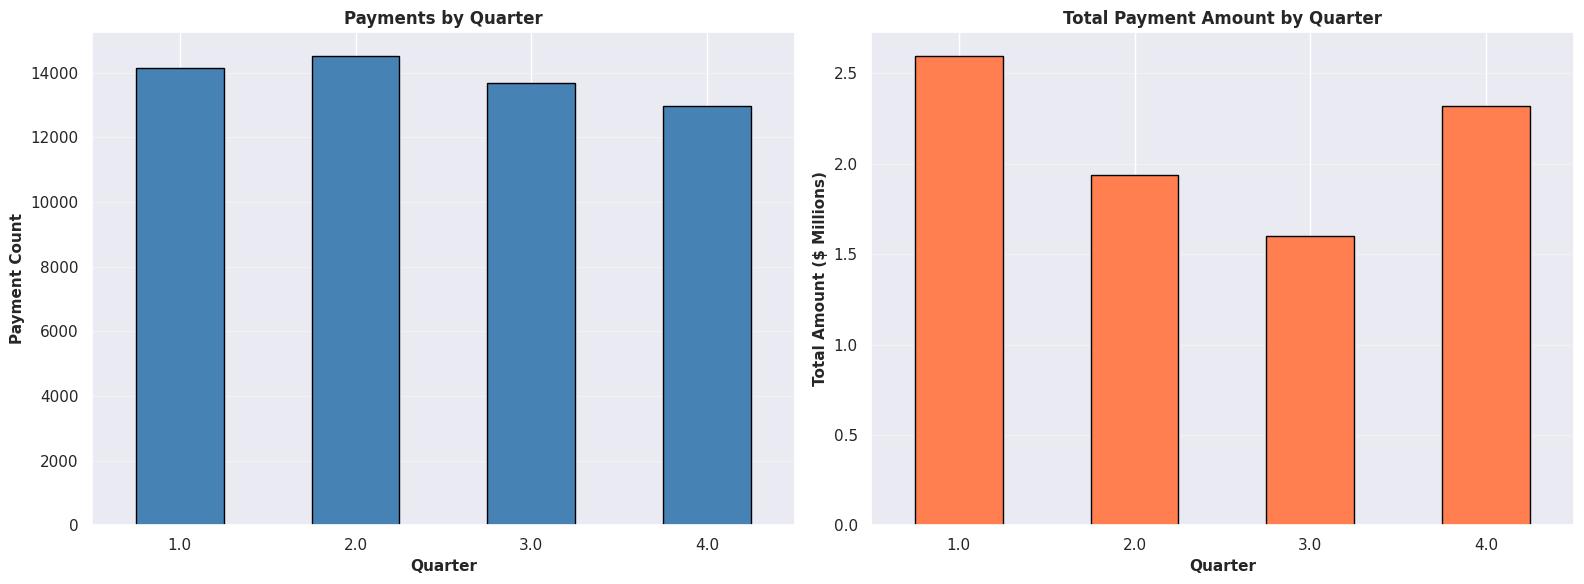

In [26]:
# Quarterly analysis
if 'payment_quarter' in df.columns and payment_col and payment_col in df.columns:
    print("=" * 70)
    print("QUARTERLY PAYMENT STATISTICS")
    print("=" * 70)
    
    quarterly_stats = df.groupby('payment_quarter')[payment_col].agg([
        'count', 'sum', 'mean', 'median'
    ]).round(2)
    
    quarterly_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)']
    quarterly_stats.index.name = 'Quarter'
    
    display(quarterly_stats)
    
    # Visualize using comprehensive quarterly trends
    if use_visualizer:
        fig = visualizer.plot_quarterly_trends(df, quarter_col='payment_quarter', 
                                              amount_col=payment_col)
        if fig:
            plt.show()
    else:
        print("Visualizer not available - skipping plot")

## 7. Geographic Analysis

Analyzing payment distributions across geographic regions.

In [27]:
# State-level statistics
state_col = 'recipient_state'

if state_col in df.columns and payment_col in df.columns:
    print("=" * 70)
    print("TOP 20 STATES BY PAYMENT METRICS")
    print("=" * 70)
    
    state_stats = df.groupby(state_col)[payment_col].agg([
        'count', 'sum', 'mean', 'median'
    ]).round(2)
    
    state_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)']
    state_stats = state_stats.sort_values('Total ($)', ascending=False).head(20)
    state_stats.index.name = 'State'
    
    display(state_stats)

TOP 20 STATES BY PAYMENT METRICS


,Count,Total ($),Mean ($),Median ($)
State,,,,
120,1,100000151638.00,100000151638.00,100000151638.00
"06360""",1,100000011150.00,100000011150.00,100000011150.00
"""YALE UNIVERSITY",1,100000010583.00,100000010583.00,100000010583.00
7B,1,100000000127.00,100000000127.00,100000000127.00
CA,4925,901381.65,183.02,23.27
IL,1834,787344.84,429.30,21.43
MO,1196,771854.48,645.36,19.12
FL,4798,613993.36,127.97,21.08
NY,3649,592245.64,162.30,22.02


### State-Level Payment Statistics

<Figure size 1500x1000 with 0 Axes>

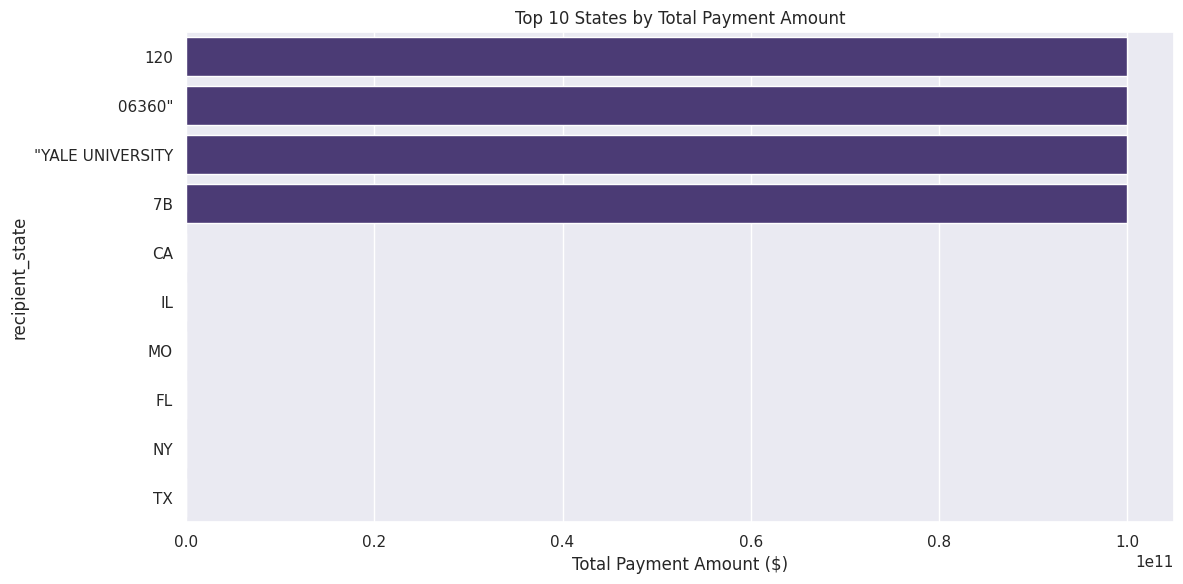

In [28]:
# Geographic analysis with basic visualization
if state_col and state_col in df.columns:
    if use_visualizer:
        # Basic geographic distribution
        fig = visualizer.plot_geographic_distribution(df, state_col=state_col)
        if fig:
            plt.show()
        
        # Additional analysis
        if payment_col and payment_col in df.columns:
            # Create separate visualization for payment amounts
            state_summary = df.groupby(state_col)[payment_col].agg([
                'count', 'sum', 'mean', 'median'
            ]).round(2)
            
            # Plot top states by payment amount
            plt.figure(figsize=(12, 6))
            top_states = state_summary['sum'].nlargest(10)
            sns.barplot(x=top_states.values, y=top_states.index)
            plt.title('Top 10 States by Total Payment Amount')
            plt.xlabel('Total Payment Amount ($)')
            plt.tight_layout()
            plt.show()


### Geographic Distribution Overview

Comprehensive view of payment distribution across states.

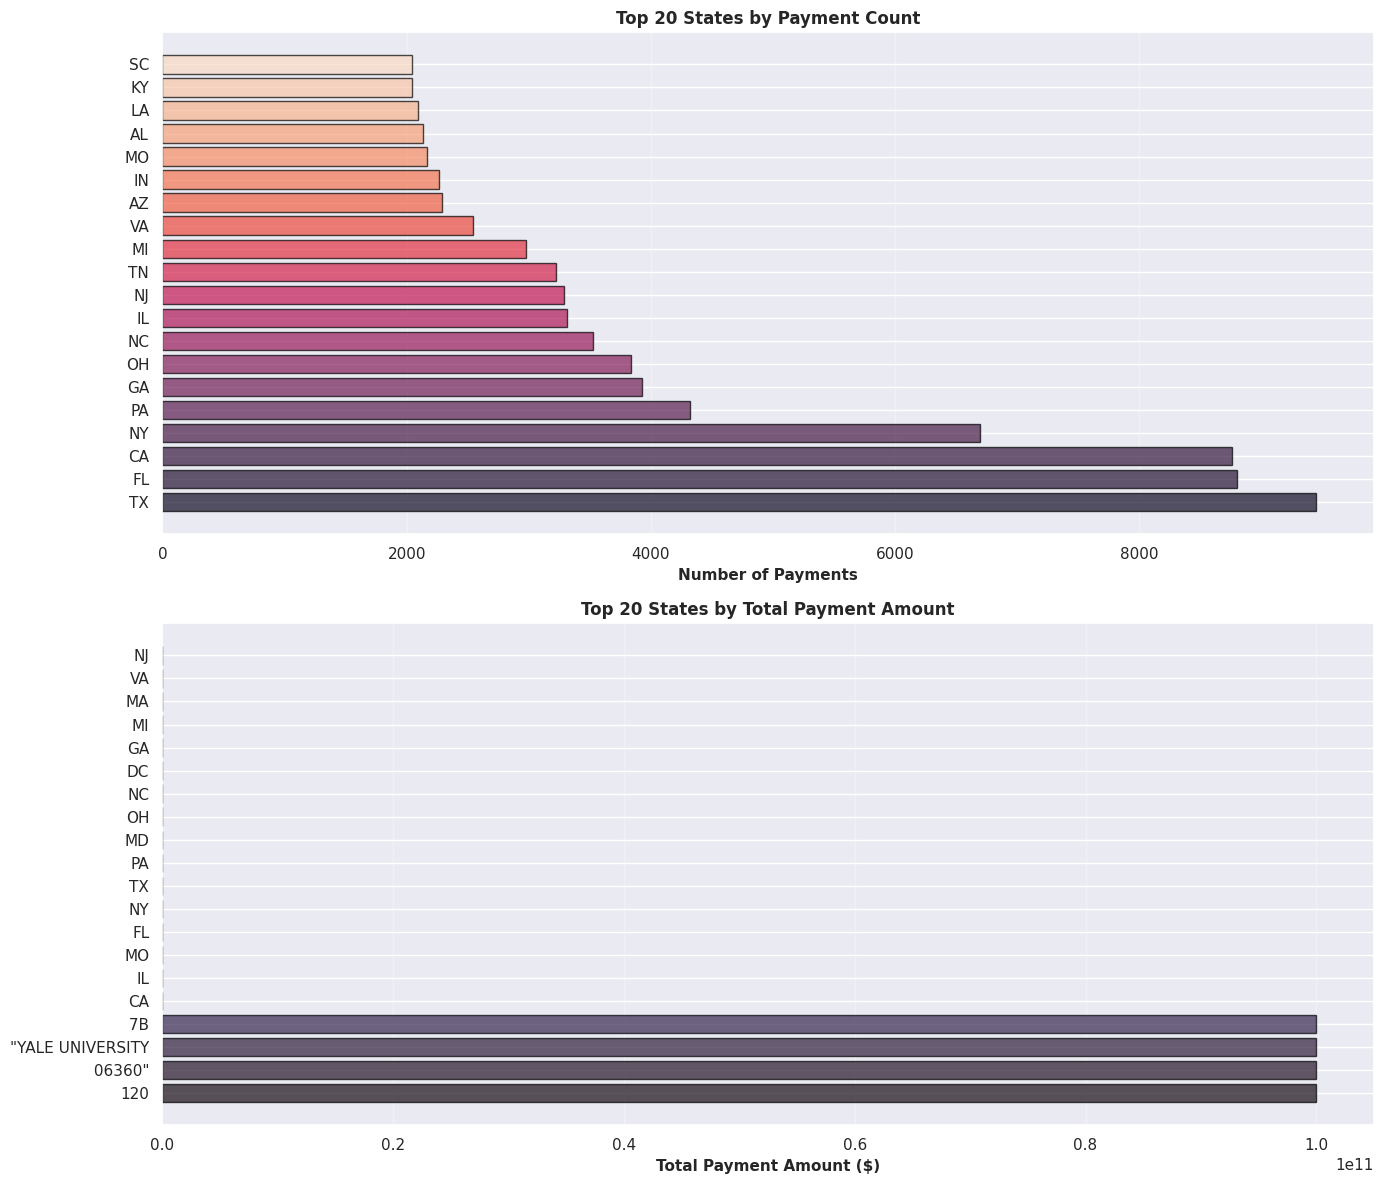

In [29]:
# Visualize geographic distribution
if state_col and state_col in df.columns and payment_col and payment_col in df.columns:
    if use_visualizer:
        fig = visualizer.plot_state_comparison(df, state_col=state_col, 
                                               payment_col=payment_col, top_n=20)
        plt.show()
    else:
        print("Visualizer not available - skipping plot")

### Interactive Geographic Maps

In [30]:
# Create aggregated features by recipient
print("=" * 70)
print("FEATURE ENGINEERING: AGGREGATED RECIPIENT METRICS")
print("=" * 70)

# Identify recipient ID column
recipient_id_cols = [col for col in df.columns if 'recipient' in col.lower() and 'id' in col.lower()]
print(f"\nAvailable recipient ID columns: {recipient_id_cols}")

if len(recipient_id_cols) > 0:
    recipient_id_col = recipient_id_cols[0]  # Use first available ID column
    print(f"Using: {recipient_id_col}")
    
    # Create aggregated features
    agg_features = df.groupby(recipient_id_col).agg({
        payment_col: ['count', 'sum', 'mean', 'median', 'std', 'min', 'max']
    }).round(2)
    
    agg_features.columns = ['_'.join(col).strip() for col in agg_features.columns.values]
    agg_features = agg_features.reset_index()
    
    print(f"\nAggregated features created: {agg_features.shape}")
    display(agg_features.head(10))
else:
    print("WARNING: No recipient ID column found for aggregation")

FEATURE ENGINEERING: AGGREGATED RECIPIENT METRICS

Available recipient ID columns: ['covered_recipient_profile_id', 'covered_recipient_middle_name']
Using: covered_recipient_profile_id

Aggregated features created: (80492, 8)


,covered_recipient_profile_id,total_amount_of_payment_usdollars_count,total_amount_of_payment_usdollars_sum,total_amount_of_payment_usdollars_mean,total_amount_of_payment_usdollars_median,total_amount_of_payment_usdollars_std,total_amount_of_payment_usdollars_min,total_amount_of_payment_usdollars_max
0,20.00,1,25.00,25.00,25.00,NaN,25.00,25.00
1,36.00,1,125.00,125.00,125.00,NaN,125.00,125.00
2,44.00,1,28.26,28.26,28.26,NaN,28.26,28.26
3,48.00,0,0.00,NaN,NaN,NaN,NaN,NaN
4,49.00,2,130.25,65.12,65.12,78.82,9.39,120.86
5,69.00,1,16.98,16.98,16.98,NaN,16.98,16.98
6,106.00,0,0.00,NaN,NaN,NaN,NaN,NaN
7,107.00,1,7.98,7.98,7.98,NaN,7.98,7.98
8,131.00,0,0.00,NaN,NaN,NaN,NaN,NaN
9,136.00,0,0.00,NaN,NaN,NaN,NaN,NaN


## 7.1 Data Partitioning 

Split the data according to project requirements 40/10/10/40

In [31]:
# data split (40/10/10/40)
print("Applying 40/10/10/40 data split...")

# fix random seed 
np.random.seed(42)

# create a random mask to assign each row to a category
perms = np.random.rand(len(df))

# map the random decimals to the four mandatory groups
df['dataset_usage'] = pd.cut(
    perms, 
    bins=[0, 0.4, 0.5, 0.6, 1.0], 
    labels=['train', 'test', 'validation', 'production']
)

# display the exact counts to confirm the split matches requirements
split_summary = df['dataset_usage'].value_counts().sort_index()
split_pct = df['dataset_usage'].value_counts(normalize=True).sort_index() * 100

print("\nFinal Partition Summary:")
for label in split_summary.index:
    print(f"  {label.capitalize()}: {split_summary[label]:,} rows ({split_pct[label]:.1f}%)")

Applying 40/10/10/40 data split...

Final Partition Summary:
  Train: 39,985 rows (40.0%)
  Test: 9,949 rows (9.9%)
  Validation: 10,061 rows (10.1%)
  Production: 40,005 rows (40.0%)


## 8. Feature Engineering

Create new features for predictive modeling.

### Baseline Engineering
Data leak prevention. This isolates the training set to establish what "normal" behavior looks for each doctor/hospital before merging them back into the main dataset. 

In [32]:
# drop existing features if they exist to prevent error
cols_to_drop = ['hist_pay_count', 'hist_pay_total', 'hist_pay_avg', 
                'hist_pay_std', 'hist_pay_max', 'amt_to_avg_ratio', 'amt_to_max_ratio']

# only drop columns that are actually in the dataframe
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# setup column names
target_id = 'covered_recipient_profile_id' 
payment_col = 'total_amount_of_payment_usdollars'
nature_col = 'nature_of_payment_or_transfer_of_value'
recipient_type_col = 'covered_recipient_type'
state_col = 'recipient_state'

# isolate training set to calculate historical "Normal" behavior
df_train = df[df['dataset_usage'] == 'train']
global_median = df_train[payment_col].median()

print(f"Calculating baselines for: {target_id}")

# calculate Recipient-Level historical metrics from training data
recipient_features = df_train.groupby(target_id).agg({
    payment_col: ['count', 'sum', 'mean', 'std', 'max']
}).reset_index()

# flatten columns so they are easy to reference
recipient_features.columns = [
    target_id, 'hist_pay_count', 'hist_pay_total', 'hist_pay_avg', 'hist_pay_std', 'hist_pay_max'
]

# merge features back to the main dataframe
# using left merge to ensure we don't lose the production/validation rows
df = df.merge(recipient_features, on=target_id, how='left')

# create ratio features 
df['amt_to_avg_ratio'] = df[payment_col] / df['hist_pay_avg']
df['amt_to_max_ratio'] = df[payment_col] / df['hist_pay_max']

# Impute NaNs (handling recipients not seen in training)
df['is_new_recipient'] = df['hist_pay_avg'].isnull().astype(int)
df['hist_pay_avg'] = df['hist_pay_avg'].fillna(global_median)
df['amt_to_avg_ratio'] = df['amt_to_avg_ratio'].fillna(df[payment_col] / global_median)

# final cleanup for remaining numerical NaNs
df[['hist_pay_count', 'hist_pay_total', 'hist_pay_std', 'hist_pay_max', 'amt_to_max_ratio']] = \
    df[['hist_pay_count', 'hist_pay_total', 'hist_pay_std', 'hist_pay_max', 'amt_to_max_ratio']].fillna(0)

Calculating baselines for: covered_recipient_profile_id


### Statistical Deviation & Imputation

In [33]:
# temporal features, extracting seasonal patterns
df['date_of_payment'] = pd.to_datetime(df['date_of_payment'])
df['payment_month'] = df['date_of_payment'].dt.month
df['is_weekend'] = (df['date_of_payment'].dt.dayofweek >= 5).astype(int)

# categorical risk indicators
risk_categories = ['Gift', 'Entertainment', 'Travel and Lodging']
df['is_high_risk_nature'] = df['nature_of_payment_or_transfer_of_value'].isin(risk_categories).astype(int)

print("Block 2 Complete: Contextual features created.")

# final verification, view the engineered data across the 40/10/10/40 split
cols_to_view = ['dataset_usage', payment_col, 'hist_pay_avg', 'amt_to_avg_ratio', 'is_new_recipient', 'is_weekend']
display(df.groupby('dataset_usage')[cols_to_view].head(3))

Block 2 Complete: Contextual features created.


,dataset_usage,total_amount_of_payment_usdollars,hist_pay_avg,amt_to_avg_ratio,is_new_recipient,is_weekend
0,train,27.41,27.41,1.00,0,0
1,production,NaN,20.12,NaN,1,0
2,production,15.54,20.12,0.77,1,0
3,validation,2048.00,20.12,101.79,1,0
4,train,8.30,8.30,1.00,0,0
5,train,12.29,12.29,1.00,0,0
7,production,NaN,20.12,NaN,1,0
17,validation,NaN,20.12,NaN,1,0
18,test,16.79,20.12,0.83,1,0
24,test,13.35,20.12,0.66,1,0


### Multi-Dimensional Anomaly Detection

In [34]:
# handle missing raw payment amounts by filling with the global training median
# this ensures that rows with NaN payments don't break the outlier detection models
df[payment_col] = df[payment_col].fillna(global_median)

# recalculate the ratio for these newly filled rows
df['amt_to_avg_ratio'] = df['amt_to_avg_ratio'].fillna(df[payment_col] / global_median)

# check for any remaining NaNs across the entire feature set
final_nan_check = df[['hist_pay_avg', 'amt_to_avg_ratio', 'is_new_recipient', 'is_weekend']].isnull().sum()
print("Remaining NaN values per feature:")
print(final_nan_check)

Remaining NaN values per feature:
hist_pay_avg        0
amt_to_avg_ratio    0
is_new_recipient    0
is_weekend          0
dtype: int64


## 9. Outlier Detection

Identify and analyze outlier payments.

In [35]:
# Outlier detection using IQR method
if payment_col in df.columns:
    print("=" * 70)
    print("OUTLIER DETECTION ANALYSIS")
    print("=" * 70)
    
    amounts = df[payment_col].dropna()
    
    # Method 1: IQR (Interquartile Range)
    Q1 = amounts.quantile(0.25)
    Q3 = amounts.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    iqr_outliers = df[(df[payment_col] < lower_bound) | (df[payment_col] > upper_bound)]
    
    print(f"\nIQR Method:")
    print(f"  Q1 (25th percentile): ${Q1:,.2f}")
    print(f"  Q3 (75th percentile): ${Q3:,.2f}")
    print(f"  IQR: ${IQR:,.2f}")
    print(f"  Lower Bound: ${lower_bound:,.2f}")
    print(f"  Upper Bound: ${upper_bound:,.2f}")
    print(f"  Outliers Detected: {len(iqr_outliers):,} ({len(iqr_outliers)/len(df)*100:.2f}%)")
    
    # Method 2: Z-Score
    z_scores = np.abs(stats.zscore(amounts))
    z_threshold = 3
    z_outliers = df[np.abs(stats.zscore(df[payment_col].fillna(0))) > z_threshold]
    
    print(f"\nZ-Score Method (threshold={z_threshold}):")
    print(f"  Outliers Detected: {len(z_outliers):,} ({len(z_outliers)/len(df)*100:.2f}%)")
    
    # Method 3: Percentile-based
    percentile_99 = amounts.quantile(0.99)
    percentile_outliers = df[df[payment_col] > percentile_99]
    
    print(f"\nPercentile Method (99th percentile):")
    print(f"  Threshold: ${percentile_99:,.2f}")
    print(f"  Outliers Detected: {len(percentile_outliers):,} ({len(percentile_outliers)/len(df)*100:.2f}%)")

OUTLIER DETECTION ANALYSIS

IQR Method:
  Q1 (25th percentile): $19.09
  Q3 (75th percentile): $21.23
  IQR: $2.14
  Lower Bound: $15.88
  Upper Bound: $24.44
  Outliers Detected: 34,162 (34.16%)

Z-Score Method (threshold=3):
  Outliers Detected: 5 (0.01%)

Percentile Method (99th percentile):
  Threshold: $1,342.57
  Outliers Detected: 1,000 (1.00%)


### Outlier Detection Methods


OUTLIER CHARACTERISTICS

Payment Amount Statistics for Outliers:
  Count: 34,162
  Mean: $14,636,385.78
  Median: $25.14
  Min: $0.01
  Max: $100,000,151,638.00

Top 10 Outliers by Payment Amount:


,total_amount_of_payment_usdollars,covered_recipient_type,recipient_state,nature_of_payment_or_transfer_of_value
95589,100000151638.00,Covered Recipient Physician,120,United States
23832,100000011150.00,Covered Recipient Non-Physician Practitioner,"06360""",United States
15496,100000010583.00,Covered Recipient Physician,"""YALE UNIVERSITY",United States
61606,100000000234.00,Covered Recipient Physician,<NA>,United States
10639,100000000127.00,Covered Recipient Non-Physician Practitioner,7B,United States
85541,627450.00,Covered Recipient Teaching Hospital,MO,"""Compensation for services other than consulting"
87165,534002.54,Covered Recipient Physician,IL,Royalty or License
83026,135000.00,Covered Recipient Teaching Hospital,DC,Space rental or facility fees (teaching hospit...
2223,80000.00,Covered Recipient Physician,UT,Debt forgiveness
21873,75646.03,Covered Recipient Physician,CA,Royalty or License


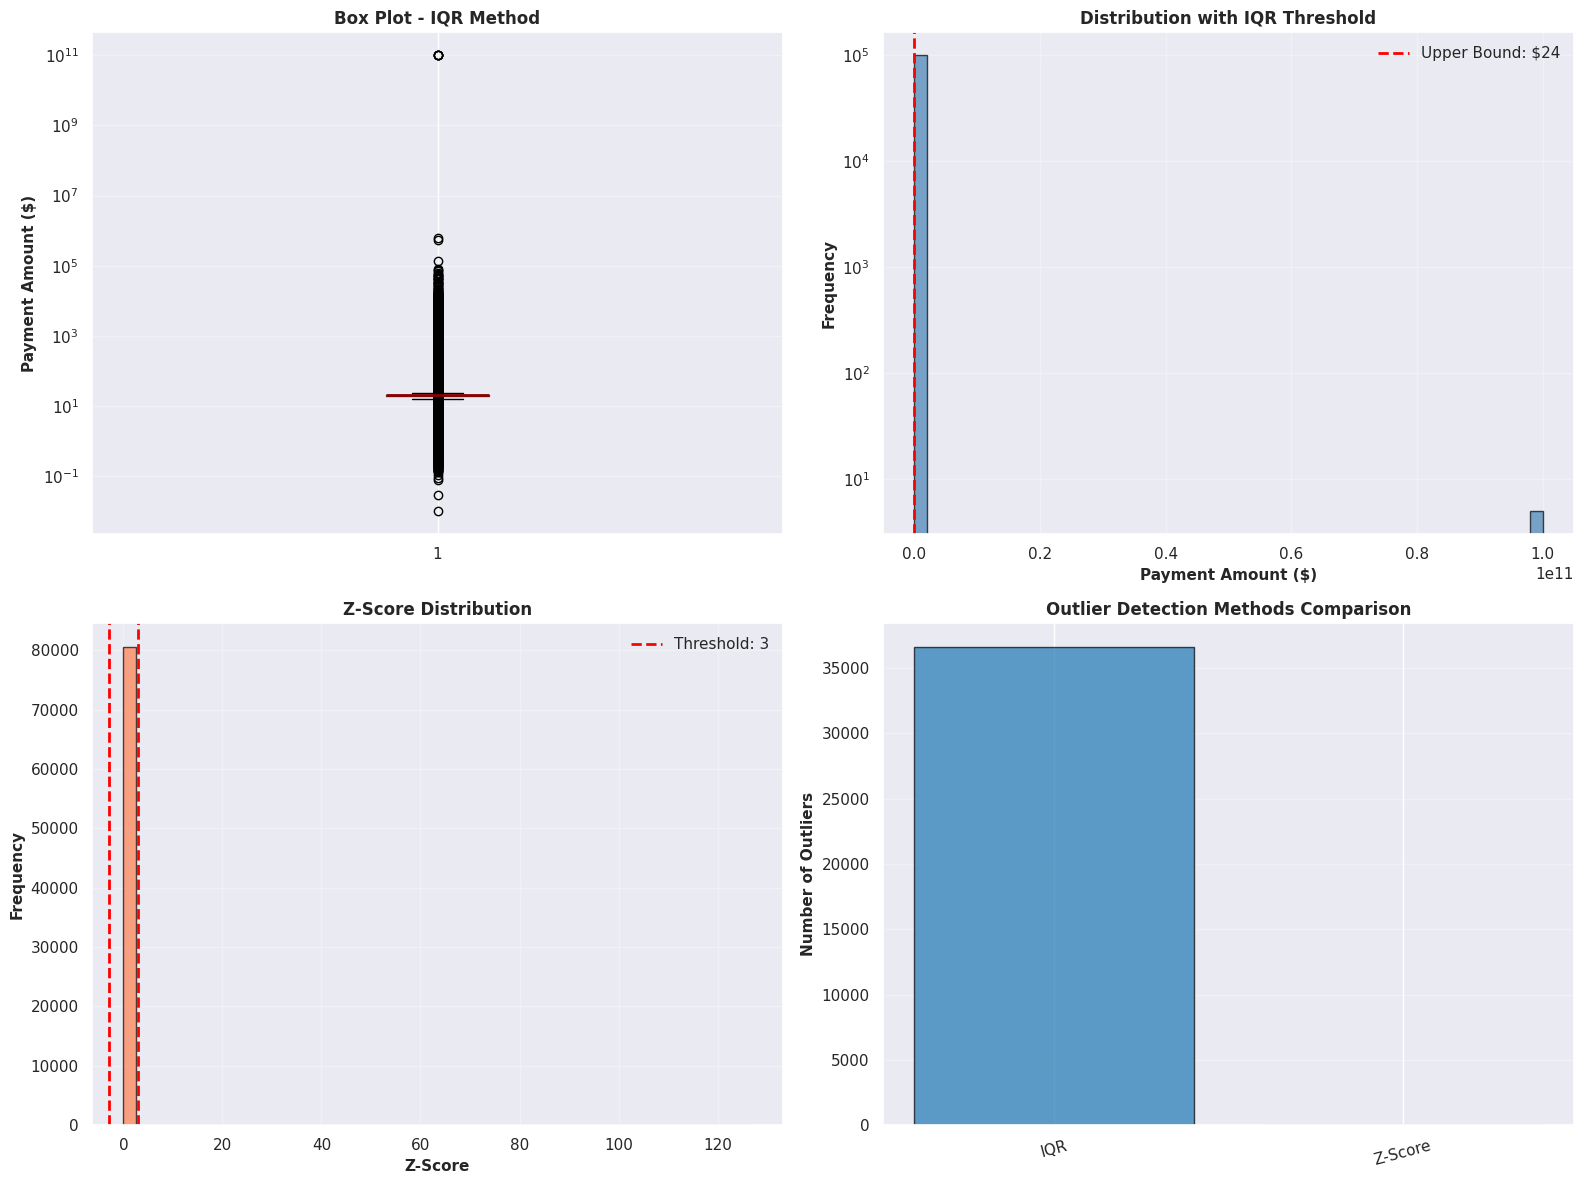

In [36]:
# Analyze outlier characteristics
if payment_col in df.columns and len(iqr_outliers) > 0:
    print("\n" + "=" * 70)
    print("OUTLIER CHARACTERISTICS")
    print("=" * 70)
    
    print(f"\nPayment Amount Statistics for Outliers:")
    print(f"  Count: {len(iqr_outliers):,}")
    print(f"  Mean: ${iqr_outliers[payment_col].mean():,.2f}")
    print(f"  Median: ${iqr_outliers[payment_col].median():,.2f}")
    print(f"  Min: ${iqr_outliers[payment_col].min():,.2f}")
    print(f"  Max: ${iqr_outliers[payment_col].max():,.2f}")

    # Top outliers
    print(f"\nTop 10 Outliers by Payment Amount:")
    top_outliers = iqr_outliers.nlargest(10, payment_col)[
        [col for col in [payment_col, recipient_type_col, state_col, nature_col] 
         if col in iqr_outliers.columns]
    ]
    display(top_outliers)
    
    # Visualize outliers
    if use_visualizer and len(recipient_id_cols) > 0:
        # Create aggregated data for outlier visualization
        df_aggregated = df.groupby(recipient_id_cols[0]).agg({
            payment_col: ['count', 'sum', 'mean']
        }).reset_index()
        df_aggregated.columns = ['recipient_id', 'payment_count', 'total_amount', 'avg_amount']
        
        fig = visualizer.plot_outliers_analysis(df_aggregated, amounts, 
                                                lower_bound, upper_bound, 
                                                z_threshold=3)
        if fig:
            plt.show()

## 10. Advanced Visualizations

Create sophisticated visualizations for deeper insights.

In [37]:
# Interactive scatter plot - Payment amount vs Count
if payment_col and payment_col in df.columns and recipient_type_col and recipient_type_col in df.columns:
    if use_visualizer and len(recipient_id_cols) > 0:
        # Aggregate by recipient
        scatter_data = df.groupby([recipient_id_cols[0], recipient_type_col]).agg({
            payment_col: ['count', 'sum']
        }).reset_index()
        
        scatter_data.columns = ['recipient_id', 'recipient_type', 'payment_count', 'total_amount']
        
        # Use visualizer for interactive scatter
        fig = visualizer.create_interactive_scatter(
            scatter_data.head(1000),  # Limit for performance
            x_col='payment_count',
            y_col='total_amount',
            color_col='recipient_type',
            size_col='total_amount',
            hover_data=['recipient_id'],
            title='Payment Frequency vs Total Amount by Recipient Type'
        )
        fig.show()
    else:
        print("Visualizer or recipient ID not available - skipping plot")

### Interactive Payment Analysis

## 11. Key Findings & Summary

Generate comprehensive summary report.

In [38]:
# Generate summary report
print("=" * 70)
print("KEY FINDINGS SUMMARY")
print("=" * 70)

print("\n1. DATASET OVERVIEW")
print(f"   - Total Records: {df.shape[0]:,}")
print(f"   - Total Columns: {df.shape[1]}")
print(f"   - Data Completeness: {(1 - df.isnull().sum().sum() / (df.shape[0] * df.shape[1]))*100:.1f}%")

if payment_col in df.columns:
    print("\n2. PAYMENT STATISTICS")
    print(f"   - Total Payment Amount: ${df[payment_col].sum():,.2f}")
    print(f"   - Average Payment: ${df[payment_col].mean():,.2f}")
    print(f"   - Median Payment: ${df[payment_col].median():,.2f}")
    print(f"   - Payment Range: ${df[payment_col].min():,.2f} - ${df[payment_col].max():,.2f}")

if recipient_type_col in df.columns:
    print("\n3. RECIPIENT DISTRIBUTION")
    type_counts = df[recipient_type_col].value_counts()
    for rtype, count in type_counts.items():
        pct = (count / len(df)) * 100
        print(f"   - {rtype}: {count:,} ({pct:.1f}%)")

if 'Payment_Month' in df.columns:
    print("\n4. TEMPORAL PATTERNS")
    month_with_most = df.groupby('Payment_Month')[payment_col].sum().idxmax()
    month_with_least = df.groupby('Payment_Month')[payment_col].sum().idxmin()
    print(f"   - Highest payment month: {month_with_most}")
    print(f"   - Lowest payment month: {month_with_least}")

if state_col in df.columns:
    print("\n5. GEOGRAPHIC DISTRIBUTION")
    print(f"   - Number of states: {df[state_col].nunique()}")
    top_state = df.groupby(state_col)[payment_col].sum().idxmax()
    top_state_amount = df.groupby(state_col)[payment_col].sum().max()
    print(f"   - Top state by total amount: {top_state} (${top_state_amount:,.2f})")

print("\n6. DATA QUALITY OBSERVATIONS")
high_missing = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False).head(3)
print(f"   - Columns with highest missingness:")
for col, pct in high_missing.items():
    if pct > 0:
        print(f"     - {col}: {pct:.1f}%")

print("\n7. OUTLIER ANALYSIS")
if payment_col in df.columns:
    print(f"   - IQR outliers: {len(iqr_outliers):,} ({len(iqr_outliers)/len(df)*100:.2f}%)")
    print(f"   - 99th percentile threshold: ${percentile_99:,.2f}")

KEY FINDINGS SUMMARY

1. DATASET OVERVIEW
   - Total Records: 100,000
   - Total Columns: 107
   - Data Completeness: 39.2%

2. PAYMENT STATISTICS
   - Total Payment Amount: $500,009,528,896.29
   - Average Payment: $5,000,095.29
   - Median Payment: $20.12
   - Payment Range: $0.01 - $100,000,151,638.00

3. RECIPIENT DISTRIBUTION
   - Covered Recipient Physician: 64,293 (64.3%)
   - Covered Recipient Non-Physician Practitioner: 35,496 (35.5%)
   - Covered Recipient Teaching Hospital: 211 (0.2%)

5. GEOGRAPHIC DISTRIBUTION
   - Number of states: 313
   - Top state by total amount: 120 ($100,000,151,658.12)

6. DATA QUALITY OBSERVATIONS
   - Columns with highest missingness:
     - covered_recipient_last_name: 100.0%
     - covered_recipient_first_name: 100.0%
     - covered_recipient_license_state_code4: 100.0%

7. OUTLIER ANALYSIS
   - IQR outliers: 34,162 (34.16%)
   - 99th percentile threshold: $1,342.57
